# Ein Hybridmodell mit LSTM-AE, DBSCAN und IF

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    adjusted_rand_score,
    homogeneity_score,
    fowlkes_mallows_score
)
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
import logging
from tensorflow.keras.layers import TimeDistributed, Dense, LSTM, Dropout, LayerNormalization, Input, Add, Bidirectional, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
import pandas as pd
import os
import sys
import logging
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
from keras.layers import LSTM, Dropout, LayerNormalization, Add, TimeDistributed, Dense
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report

2025-06-18 13:28:05.536979: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-18 13:28:05.539087: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 13:28:05.571109: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-18 13:28:05.571943: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-06-18 13:28:06.082225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## 1. Vorbereitung

#### Cuda auslassen, weil DGX verwendet wird

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#### Daten laden

In [3]:
data_train = pd.read_json("train_logs.json", lines=False)
data_test = pd.read_json("test_logs.json", lines=False)
data_val = pd.read_json("val_logs.json", lines=False)
print(data_test.head())

                         timestamp    log_type   userId       ipAddress  \
0 2025-06-13 10:49:10.224667+02:00  user_event   user_6    47.131.42.45   
1 2025-06-13 10:49:10.225369+02:00  user_event  user_23  18.103.212.126   
2 2025-06-13 10:49:10.225742+02:00  user_event  user_48   85.34.127.123   
3 2025-06-13 10:49:10.226049+02:00  user_event  user_30   80.23.143.220   
4 2025-06-13 10:49:10.226544+02:00  user_event  user_19    40.19.76.123   

                                 roles    realmId      clientId  \
0                             [member]   frontend  frontend-app   
1    [user, viewer, uma_authorization]   frontend  frontend-app   
2    [member, uma_authorization, user]   internal  frontend-app   
3    [member, user, uma_authorization]  app-users  frontend-app   
4  [uma_authorization, offline_access]  app-users  frontend-app   

       authMethod authType                                            details  \
0            saml     code  {'connection': 'saml', 'user_agent': 

#### NaN-Werte bereinigen

In [4]:
X_train_full = pd.DataFrame(data_train)
X_test_full = pd.DataFrame(data_test)
X_val_full = pd.DataFrame(data_val)

X_train_full = X_train_full.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
X_test_full = X_test_full.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)
X_val_full = X_val_full.apply(lambda col: pd.to_numeric(col, errors='coerce')).fillna(0)

y_test_full = data_test["label"]

#### Logging

In [5]:
logfile = open("output_log.txt", "w")
logging.basicConfig(stream=logfile, level=logging.INFO)

sys.stdout = logfile
sys.stderr = logfile

print("Das ist eine Print-Ausgabe.")
logging.info("Das ist eine Log-Nachricht.")

#### Automatisch alles in Numerische oder Kategorische Daten einteilen

In [6]:
def auto_encode_features(logs, one_hot_numeric=False, 
                         label_encoders=None, onehot_encoders=None, fit=True):
    if logs is None or len(logs) == 0:
        return [], {}, {}

    if hasattr(logs, "to_dict"):
        logs = logs.to_dict(orient='records')

    if label_encoders is None:
        label_encoders = {}
    if onehot_encoders is None:
        onehot_encoders = {}

    sample = logs[0]
    all_keys = sample.keys()
    encoded_logs = []

    for log in logs:
        encoded = {}
        for key in all_keys:
            val = log.get(key)

            if val is None:
                continue

            if isinstance(val, (int, float)) and not isinstance(val, bool):
                if one_hot_numeric:
                    if key not in onehot_encoders and fit:
                        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
                        values = np.array([[l.get(key)] for l in logs if l.get(key) is not None])
                        encoder.fit(values)
                        onehot_encoders[key] = encoder

                    if key in onehot_encoders:
                        enc = onehot_encoders[key].transform([[val]])[0]
                        for i, v in enumerate(enc):
                            encoded[f"{key}_{i}"] = v
                else:
                    encoded[key] = val

            elif isinstance(val, str):
                if key not in label_encoders and fit:
                    le = LabelEncoder()
                    values = [l.get(key) for l in logs if l.get(key) is not None]
                    le.fit(values)
                    label_encoders[key] = le

                if key in label_encoders:
                    encoded[key] = label_encoders[key].transform([val])[0]

            elif isinstance(val, list):
                for i, item in enumerate(val):
                    label = f"{key}_{i}"
                    if label not in label_encoders and fit:
                        le = LabelEncoder()
                        values = [item for l in logs for item in l.get(key, [])]
                        le.fit(values)
                        label_encoders[label] = le

                    if label in label_encoders:
                        encoded[label] = label_encoders[label].transform([item])[0]
        encoded_logs.append(encoded)

    return encoded_logs, label_encoders, onehot_encoders


#### Werte aus vorheriger Funktion vereinigen

In [7]:
def dicts_to_feature_matrix(encoded_logs):
    feature_names = sorted({key for d in encoded_logs for key in d.keys()})

    X = np.zeros((len(encoded_logs), len(feature_names)), dtype=np.float32)

    for i, d in enumerate(encoded_logs):
        for j, feat in enumerate(feature_names):
            if feat in d:
                X[i, j] = d[feat]

    return X, feature_names

In [8]:
logs_train = X_train_full.to_dict(orient='records')
logs_test = X_test_full.to_dict(orient='records')
logs_val = X_val_full.to_dict(orient='records')

encoded_logs, label_encoders, onehot_encoders = auto_encode_features(logs_train, 
                                                one_hot_numeric=False, fit=True)
X_train, feature_names = dicts_to_feature_matrix(encoded_logs)

encoded_test_logs, _, _ = auto_encode_features(logs_test, one_hot_numeric=False,
                                               label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False)
X_test, _ = dicts_to_feature_matrix(encoded_test_logs)

encoded_val_logs, _, _ = auto_encode_features(logs_val, one_hot_numeric=False,
                                              label_encoders=label_encoders, onehot_encoders=onehot_encoders, fit=False)
X_val, _ = dicts_to_feature_matrix(encoded_val_logs)

#### Skalierung

In [9]:
# Werte skalieren
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_full.to_numpy()).astype(np.float32)
X_test_scaled = scaler.transform(X_test_full.reindex(columns=X_train_full.columns, fill_value=0).to_numpy()).astype(np.float32)
X_val_scaled = scaler.transform(X_val_full.reindex(columns=X_train_full.columns, fill_value=0).to_numpy()).astype(np.float32)

#### PCA zur Dimensionsreduktion

In [10]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
X_val_pca = pca.transform(X_val_scaled)

### Parameter

In [11]:
seq_length = 32
batch_size = 128

encoder_layers = [1024, 512, 256]
decoder_layers = [256, 512, 1024]

dropout_rate = 0.2

timesteps = seq_length
n_features = X_train_pca.shape[1]
learning_rate = 0.0001


### Sequenzen

In [12]:
# Generatoren bleiben gleich
class SequenceToSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, seq_length, batch_size):
        self.data = data
        self.seq_length = seq_length
        self.batch_size = batch_size
        self.indices = np.arange(len(data) - seq_length)

    def __len__(self):
        return (len(self.indices) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        if len(batch_idx) == 0:
            batch_idx = self.indices[-self.batch_size:]
        X_batch = np.array([self.data[i:i + self.seq_length] for i in batch_idx])
        return X_batch, X_batch

train_gen = SequenceToSequenceGenerator(X_train_pca, seq_length, batch_size)
val_gen = SequenceToSequenceGenerator(X_val_pca, seq_length, batch_size)
test_gen = SequenceToSequenceGenerator(X_test_pca, seq_length, batch_size)

## 2. LSTM-AE implementieren

In [13]:
from tensorflow.keras import backend as K

inputs = Input(shape=(timesteps, n_features))
x = inputs

def residual_lstm_block(x, units, dropout_rate=0.2):
    shortcut = x
    x = LSTM(units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization()(x)

    print("Shape x:", K.int_shape(x))
    print("Shape shortcut:", K.int_shape(shortcut))
    
    if K.int_shape(shortcut)[-1] != units:
        shortcut = TimeDistributed(Dense(units))(shortcut)
        print("Shortcut after Dense:", K.int_shape(shortcut))
    
    x = Add()([x, shortcut])
    return x

inputs = Input(shape=(timesteps, n_features))
x = inputs

for units in encoder_layers:
    x = residual_lstm_block(x, units, dropout_rate=dropout_rate)

encoded = Bidirectional(LSTM(encoder_layers[-1]))(x)
print("Encoded shape:", K.int_shape(encoded))  # (None, units*2)

decoded = RepeatVector(timesteps)(encoded)
print("Decoded shape:", K.int_shape(decoded))  # (None, timesteps, units*2)

x = decoded
for units in decoder_layers:
    x = LSTM(units, return_sequences=True)(x)
    x = Dropout(dropout_rate)(x)
    x = LayerNormalization()(x)
    print("Decoder layer output shape:", K.int_shape(x))

outputs = TimeDistributed(Dense(n_features, activation='linear'))(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate), loss='mse')
model.summary()

In [14]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(train_gen, validation_data=val_gen, epochs=100, callbacks=[early_stop])

### Umwandlung der Daten für nächste Modelle: Rekonstruktionsfehler berechnen

In [15]:
def get_reconstruction_errors(gen, model):
    errors = []
    for i in range(len(gen)):
        X_batch, _ = gen[i]
        pred = model.predict(X_batch, verbose=0)
        batch_errors = np.mean(np.square(X_batch - pred), axis=(1, 2))
        errors.extend(batch_errors)
    return np.array(errors)

train_errors = get_reconstruction_errors(train_gen, model)
reconstruction_errors = get_reconstruction_errors(test_gen, model)
threshold = np.percentile(train_errors, 75)

y_test_seq = np.array([y_test_full[i + seq_length - 1] for i in range(len(reconstruction_errors))])
true_labels = y_test_seq.astype(int)
fpr, tpr, thresholds = roc_curve(true_labels, reconstruction_errors)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

y_pred = (reconstruction_errors > optimal_threshold).astype(int)

precision, recall, f1, _ = precision_recall_fscore_support(true_labels, y_pred, average='binary')
roc_auc = roc_auc_score(true_labels, reconstruction_errors)
logging.info(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-Score: {f1:.3f}, ROC-AUC: {roc_auc:.3f}")

In [16]:
# Encoder-Model bauen
encoder = tf.keras.Model(inputs, encoded)

# Batchweise encodieren, um RAM zu sparen
X_encoded_batches = []
for i in range(len(test_gen)):
    X_batch, _ = test_gen[i]
    encoded_batch = encoder.predict(X_batch, batch_size=len(X_batch), verbose=0)
    X_encoded_batches.append(encoded_batch)
X_encoded_new = np.vstack(X_encoded_batches)

scaler_enc = StandardScaler()
X_encoded_scaled = scaler_enc.fit_transform(X_encoded_new)
X_encoded_scaled = X_encoded_scaled[-len(reconstruction_errors):]

scaler_err = StandardScaler()
reconstruction_errors_reshaped = reconstruction_errors.reshape(-1, 1)
reconstruction_errors_scaled = scaler_err.fit_transform(reconstruction_errors_reshaped)
hybrid_features = np.hstack((X_encoded_scaled, reconstruction_errors_scaled))

In [17]:
X_temp, X_test, y_temp, y_test = train_test_split(
    hybrid_features,
    true_labels,
    test_size=0.2,
    random_state=42,
    stratify=true_labels
)

# Dann: 12.5 % von 80 % ergibt 10 % des gesamten Datensatzes für Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.125,  # 0.125 * 0.8 ≈ 0.10 vom Gesamtdatensatz
    random_state=42,
    stratify=y_temp
)

# Modell 1

## Isolation Forest

In [18]:
# Trainiere nur auf Trainingsdaten
iforest = IsolationForest(random_state=42)
#iforest.fit(X_train)

# Vorhersage auf VALIDIERUNGSDATEN
val_preds = iforest.fit_predict(X_val)
val_anomaly = (val_preds == -1).astype(int)

report_iforest = classification_report(y_val, val_anomaly)
logging.info("Isolation Forest - Validation Report:\n" + report_iforest)

### IF MCC

In [19]:
mcc = matthews_corrcoef(y_val, val_anomaly)
logging.info("Matthews Correlation Coefficient: %f", mcc)

### IF Balanced Accuracy

In [20]:
balanced_acc = balanced_accuracy_score(y_val, val_anomaly)
logging.info("Balanced Accuracy: %f", balanced_acc)

### IF AUC-Kurven

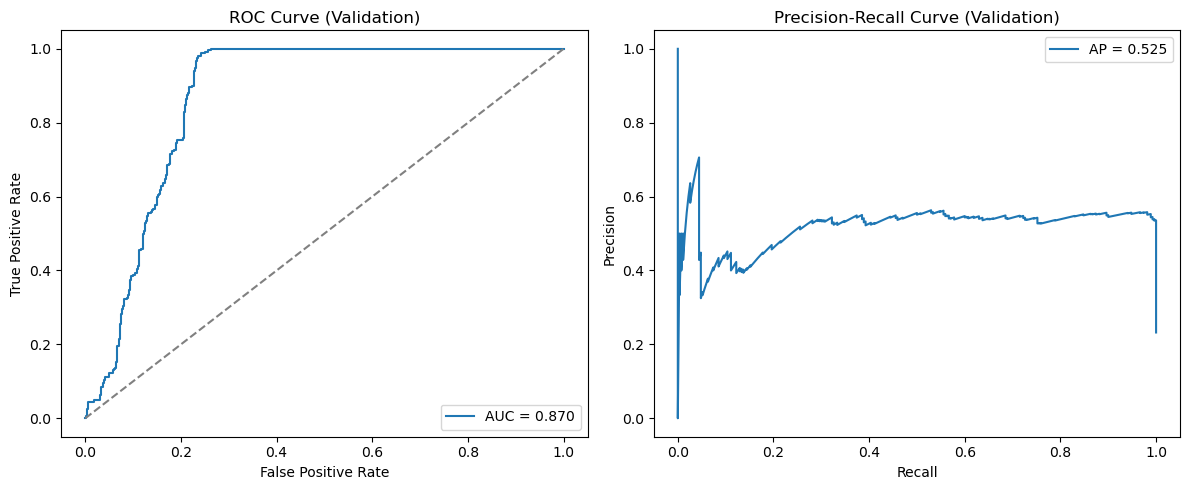

In [21]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Entscheidungsscores holen (höher = normal → invertieren für Anomalie)
val_scores = -iforest.decision_function(X_val)

# ROC-Kurve und AUC
fpr, tpr, _ = roc_curve(y_val, val_scores)
roc_auc = roc_auc_score(y_val, val_scores)

# PR-Kurve und Average Precision
precision, recall, _ = precision_recall_curve(y_val, val_scores)
pr_auc = average_precision_score(y_val, val_scores)

# Plotten
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()

# PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()

plt.tight_layout()
plt.show()


### IF: Anomaly Scores berechnen

In [22]:
scores = iforest.decision_function(hybrid_features)
print("Scores:", scores[:10])

# Modell 2

## One-Class SVM

In [23]:
# Training
ocsvm = OneClassSVM(kernel="rbf", gamma='auto', nu=0.05)  # nu ~ erwarteter Anteil Anomalien
#ocsvm.fit(X_train)

val_preds = ocsvm.fit_predict(X_val)
val_anomaly = (val_preds == -1).astype(int)

report_ocsvm = classification_report(y_val, val_anomaly)
logging.info("One-Class SVM - Validation Report:\n" + report_ocsvm)

### OCSVM MCC

In [24]:
mcc = matthews_corrcoef(y_val, val_anomaly)
logging.info("Matthews Correlation Coefficient: %f", mcc)

### OCSVM Balanced Accuracy

In [25]:
balanced_acc = balanced_accuracy_score(y_val, val_anomaly)
logging.info("Balanced Accuracy: %f", balanced_acc)

### OCSVM AUC-Kurven

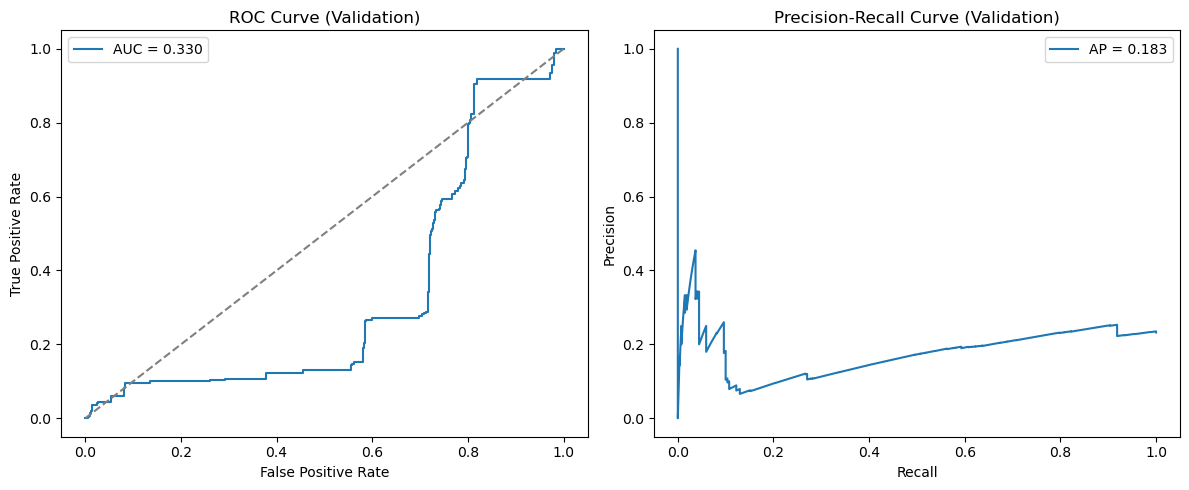

In [26]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Anomalie-Scores holen (höher = normal, deshalb invertieren)
val_scores = -ocsvm.decision_function(X_val)

# ROC-Kurve und AUC
fpr, tpr, _ = roc_curve(y_val, val_scores)
roc_auc = roc_auc_score(y_val, val_scores)

# Precision-Recall-Kurve und Average Precision
precision, recall, _ = precision_recall_curve(y_val, val_scores)
pr_auc = average_precision_score(y_val, val_scores)

# Plotten
plt.figure(figsize=(12, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()

# PR Curve
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()

plt.tight_layout()
plt.show()


### OCSVM: Anomaly-Scores berechnen

In [27]:
scores_ocsvm = ocsvm.decision_function(hybrid_features)
print("OCSVM Scores:", scores_ocsvm[:10])

# Modell 3

## DBSCAN

In [28]:
dbscan = DBSCAN(eps=0.5, min_samples=5)  
dbscan_labels = dbscan.fit_predict(X_test)
dbscan_anomaly = (dbscan_labels == -1).astype(int)
logging.info("\n" + classification_report(y_test, dbscan_anomaly))

### DBSCAN Werte: ARI, HOMO, FMI, Noise Ratio

In [29]:
ari  = adjusted_rand_score(y_test, dbscan_anomaly)
homo = homogeneity_score(y_test, dbscan_anomaly)
fmi  = fowlkes_mallows_score(y_test, dbscan_anomaly)
noise_ratio = np.sum(dbscan_labels == -1) / len(dbscan_labels)

logging.info(f"Adjusted Rand Index (ARI):     {ari:.4f}")
logging.info(f"Homogeneity:                   {homo:.4f}")
logging.info(f"Fowlkes-Mallows Index (FMI):   {fmi:.4f}")
logging.info(f"Noise Ratio: {noise_ratio:.2f}")

### DBSCAN MCC

In [30]:
mcc = matthews_corrcoef(y_test, dbscan_anomaly)
logging.info("Matthews Correlation Coefficient: %f", mcc)

### DBSCAN Balanced Accuracy

In [31]:
balanced_acc = balanced_accuracy_score(y_test, dbscan_anomaly)
logging.info("Balanced Accuracy: %f", balanced_acc)

### DBSCAN AUC-Kurven

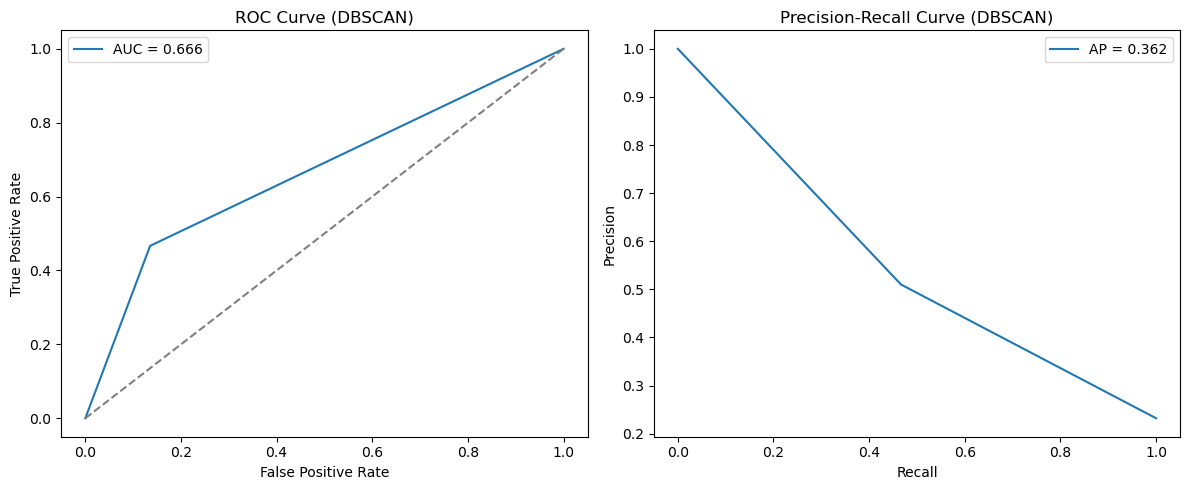

In [32]:
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Nutze die binäre Anomalie-Maske als "Score" (0 = normal, 1 = Anomalie)
# → das ergibt eine einzelne Schwelle (wenig Aussagekraft, aber technisch machbar)
scores = dbscan_anomaly  # 0 oder 1

# ROC
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = roc_auc_score(y_test, scores)

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, scores)
pr_auc = average_precision_score(y_test, scores)

# Plotten
plt.figure(figsize=(12, 5))

# ROC
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (DBSCAN)")
plt.legend()

# PR
plt.subplot(1, 2, 2)
plt.plot(recall, precision, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (DBSCAN)")
plt.legend()

plt.tight_layout()
plt.show()
